### Natural Language Processing - Text Classification using Seinfeld Transcript Data

##### 0 - Setting up required imports, importing data, and cleaning data.

In [1]:
## for data
import pandas as pd
import numpy as np
from itertools import chain
import pickle

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk
import wordcloud

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.preprocessing import LabelEncoder

## for explainer
from lime import lime_text

## for word embedding (Word2Vec)
import gensim
from gensim.models import Word2Vec

## for deep learning
from tensorflow import keras
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras import regularizers

## for bert language model
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

In [2]:
# read the generated transcripts CSV from Data Scraper ipynb
seinfeldDF = pd.read_csv('seinfeld_transcripts.csv')

In [3]:
# Some Data Cleaning
# transpose the data frame
seinfeldDFT = seinfeldDF.T
# ravel the data frame to put all columns into one centralized column, drop na's, lower case
cleanedDF = pd.Series(seinfeldDFT.values.ravel('F')).dropna()
cleanedDF = cleanedDF.to_frame(name='Character')
cleanedDF['Character'] = cleanedDF['Character'].str.lower()

# separate the character from the text and keep the 4 most popular
cleanedDF[['Character','Character Text']] = cleanedDF["Character"].str.split(":", 1, expand=True)
cleanedDF = cleanedDF.dropna()

##### 1 - Text Analysis and Cleaning

In [4]:
# lets take a look at the distribution of characters and their lines
cleanedDF.Character.str.split(expand=True).stack().value_counts()

jerry          9723
george         6494
elaine         5267
kramer         4335
newman          459
               ... 
has               1
roughed           1
convincing)       1
slices            1
example           1
Length: 2386, dtype: int64

Unsurprisingly, Jerry has the most lines followed by George, Elaine, and Kramer. We will use these 4 characters as our primary predictor targets.
Next I clean the data to only include these characters and remove the text in parenthesis (not spoken by the character)

In [4]:
# clean character col for jerry, george, elaine, and kramer
cleanedDF = cleanedDF[(cleanedDF['Character'] == 'jerry') 
                      | (cleanedDF['Character'] == 'george') 
                      | (cleanedDF['Character'] == 'elaine') 
                      | (cleanedDF['Character'] == 'kramer')]

# clean character text from brackets, characters do not say these lines
cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\[.*\]","")
cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\(.*\)","")
cleanedDF.sample(5)

<ipython-input-4-b8cb78b855a7>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\[.*\]","")
<ipython-input-4-b8cb78b855a7>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  cleanedDF['Character Text'] = cleanedDF['Character Text'].str.replace(r"\(.*\)","")


,Character,Character Text
50435,elaine,"hey, do you believe i got happy new year toda..."
54161,george,", we'll see you in a little while."
81500,george,"jerry, would you make the call already?"
26429,george,..okay.
46803,jerry,"hey, shall we spit on him?"


In [6]:
cleanedDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24777 entries, 21738 to 86925
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Character       24777 non-null  object
 1   Character Text  24777 non-null  object
dtypes: object(2)
memory usage: 580.7+ KB


<AxesSubplot:>

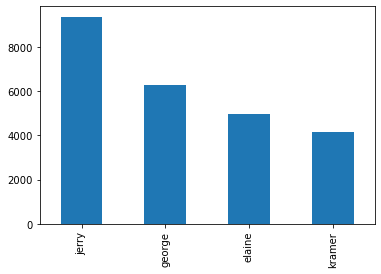

In [7]:
# plot distribution
cleanedDF.Character.value_counts().plot(kind='bar')

In [8]:
# display values. this helps determine our baseline for accuracy when we build out models
cleanedDF.Character.value_counts()

jerry     9358
george    6263
elaine    4989
kramer    4167
Name: Character, dtype: int64

##### 2 - Pre-processing
In this step, the character text col will be modified by tokenization, removal of stop words, stemming, and lemmatization. source: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [9]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


In [10]:
# download NLTK data, un-comment these out if you don't have it
# nltk.download('wordnet')
# nltk.download('stopwords')

# obtain stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")
cleanedDF["Character Text_clean"] = cleanedDF["Character Text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
cleanedDF.head()

,Character,Character Text,Character Text_clean
21738,jerry,"you know, why we're here? ""he didn't tell me...",know didnt tell going must gone wanna go get r...
21741,jerry,"seems to me, that button is in the worst poss...",seems button worst possible spot second button...
21742,george,are you through?,
21743,jerry,"you do of course try on, when you buy?",course try buy
21744,george,"yes, it was purple, i liked it, i don't actua...",yes purple liked dont actually recall consider...


In [11]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(cleanedDF, test_size=0.3)
## get target
y_train = dtf_train["Character"].values
y_test = dtf_test["Character"].values

##### 3 - Baseline Model

For the baseline model, we will use naive bayes as its extremely quick train time will provide an idea of whether the model can predict better than baseline accuracy.
Feature Engineering: use tf-idf vectorizer to extract info from the data

Text(0.5, 1.0, 'Sparse Matrix Sample')

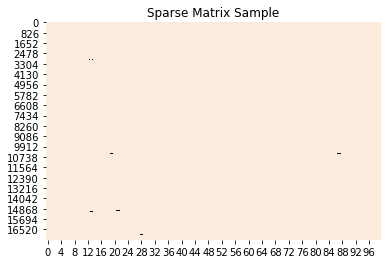

In [12]:
## Tf-Idf (advanced variant of BoW)
# from sklearn, use feature extraction to convert words into vectors
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

corpus = dtf_train["Character Text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, 
            cbar=False).set_title('Sparse Matrix Sample')

The matrix is fairly sparse, we can reduce dimensionality with feature selection.
We can treat each category as binary and do a Chi-Square test to determine whether a feature and the (binary) target are independent

In [13]:
# chi-square test
y = dtf_train["Character"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [14]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# elaine:
  . selected features: 273
  . top features: hi,bike,mr peterman,um,oh,lippman,peterman,ugh,mr lippman,pitt
 
# george:
  . selected features: 233
  . top features: moops,seven,yeah,susan,course,aware,soda,bozo,twix,newman
 
# jerry:
  . selected features: 66
  . top features: jerry,uh,leo,elaine,ha,hello newman,uncle leo,mr,dunno,name
 
# kramer:
  . selected features: 443
  . top features: buddy,hey,yeah,hey buddy,oh hey,hey jerry,jerry,uh yeah,well,rusty
 


Text(0.5, 1.0, 'Sparse Matrix Sample')

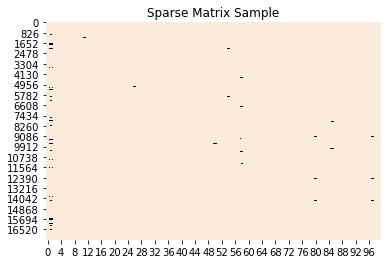

In [15]:
# repeat visualization
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')


The matrix is now a little less sparse

##### Naive Bayes Model

In [16]:
classifier = naive_bayes.MultinomialNB()

In [17]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["Character Text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.42
Auc: 0.6
Detail:
              precision    recall  f1-score   support

      elaine       0.48      0.10      0.16      1472
      george       0.40      0.13      0.20      1890
       jerry       0.41      0.91      0.56      2837
      kramer       0.50      0.10      0.17      1235

    accuracy                           0.42      7434
   macro avg       0.45      0.31      0.27      7434
weighted avg       0.44      0.42      0.33      7434



(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'elaine'),
  Text(0, 1.5, 'george'),
  Text(0, 2.5, 'jerry'),
  Text(0, 3.5, 'kramer')])

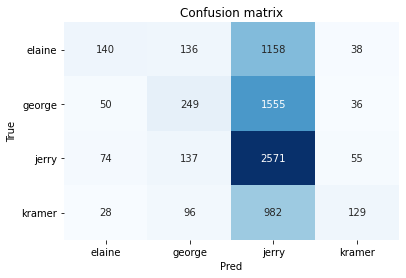

In [18]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


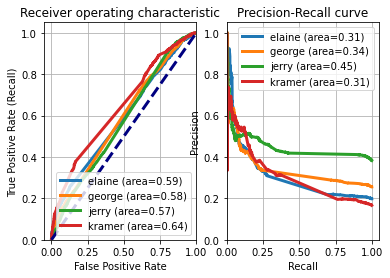

In [19]:
## Plot roc
fig, ax = plt.subplots(nrows=1, ncols=2)

for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

The model is able to produce accuracy of 42%, which is higher than the baseline accuracy blindly guessing Jerry for all test labels (37.8%). Given the above ROC (0.6) we can understand that it has a poor time distinguishing between the characters.

##### BERT - source: https://swatimeena989.medium.com/distilbert-text-classification-using-keras-c1201d3a3d9d

In [169]:
# setup for distilBERT -> labeled as dbert
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# setup for sentance and label matching of seinfeld scripts
max_len=32
num_classes=len(cleanedDF.Character.unique())
sentences=cleanedDF['Character Text']
labels=cleanedDF['Character']
len(sentences),len(labels)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


(24777, 24777)

In [12]:
#dbert_inp=dbert_tokenizer.encode_plus(sentences[0],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)

In [170]:
# Create a basic NN model using DistilBERT embeddings to get the predictions
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [171]:
model=create_model()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 66362880    input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 768)          0           tf_distil_bert_model_2[0][0

In [172]:
# create id and mask layers
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

C:\Users\Victor\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
# confirm that 3 layers are all equal size
len(input_ids),len(attention_masks),len(labels)

(24777, 24777, 24777)

In [31]:
# save to local folder for ease of use if required in the future
print('Preparing the pickle file.....')

pickle_inp_path='./data/dbert_inp.pkl'
pickle_mask_path='./data/dbert_mask.pkl'
pickle_label_path='./data/dbert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./data/dbert_inp.pkl ./data/dbert_mask.pkl ./data/dbert_label.pkl


In [32]:
# load saved files
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (24777, 32) Attention mask shape (24777, 32) Input label shape (24777,)


In [33]:
# split layers into train and test, 80% and 20% respectively
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

# define where to save the model as running this took ~20 mins per epoch
log_dir='dbert_model'
model_save_path='./dbert_model.h5'
# callback to save the model
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
# metrics
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (19821, 32) Val input shape (4956, 32)
Train label shape (19821,) Val label shape (4956,)
Train attention mask shape (19821, 32) Val attention mask shape (4956, 32)


In [133]:
#callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
#model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [165]:
# before running dbert model
# convert categorical data in labels to 0, 1, etc..
label_encoder = LabelEncoder()
train_label = np.array(label_encoder.fit_transform(train_label))
val_label = np.array(label_encoder.fit_transform(val_label))
train_label,val_label

(array([2, 0, 3, ..., 0, 0, 3], dtype=int64),
 array([3, 2, 1, ..., 0, 0, 1], dtype=int64))

In [153]:
# run and save the model. this takes ~20 mins per epoch
history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=5,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/5
1239/1239 [==============================] - 1535s 1s/step - loss: 3.2020 - accuracy: 0.4445 - val_loss: 2.6332 - val_accuracy: 0.4502
Epoch 2/5
1239/1239 [==============================] - 1528s 1s/step - loss: 2.1373 - accuracy: 0.5478 - val_loss: 2.1151 - val_accuracy: 0.4550
Epoch 3/5
1239/1239 [==============================] - 1503s 1s/step - loss: 1.4913 - accuracy: 0.6735 - val_loss: 1.9589 - val_accuracy: 0.4538
Epoch 4/5
1239/1239 [==============================] - 1503s 1s/step - loss: 1.0494 - accuracy: 0.7652 - val_loss: 1.9660 - val_accuracy: 0.4471
Epoch 5/5
1239/1239 [==============================] - 1530s 1s/step - loss: 0.7722 - accuracy: 0.8220 - val_loss: 2.1034 - val_accuracy: 0.4338


In [173]:
# create the trained model and save as "dbert_model.h5" 
# note this file was ~250MB and will not be on github
trained_model = create_model()
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 66362880    input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 768)          0           tf_distil_bert_model_2[1][0

In [174]:
# determine and print f1 score
preds = trained_model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)

f1 = f1_score(val_label,pred_labels,average='micro')
f1

0.7441485068603714

In [175]:
# print metrics
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))
# note that encoding was done using label_encoder.fit_transform which encodes alphabetically
# 0 = elaine, 1 = george, 2 = jerry, 3 = kramer

F1 score 0.7441485068603714
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1014
           1       0.83      0.64      0.72      1247
           2       0.70      0.85      0.77      1862
           3       0.83      0.71      0.77       833

    accuracy                           0.74      4956
   macro avg       0.76      0.73      0.74      4956
weighted avg       0.75      0.74      0.74      4956



In [180]:
# for ROC curve we need to sort val_labels into 0s and 1s per category in order to graph
temp0 = []
temp1 = []
temp2 = []
temp3 = []
for i in val_label:
    if i == 0:
        temp0.append(i+1)
        temp1.append(0)
        temp2.append(0)
        temp3.append(0)
    elif i == 1:
        temp1.append(i)
        temp0.append(0)
        temp2.append(0)
        temp3.append(0)
    elif i == 2:
        temp2.append(i-1)
        temp1.append(0)
        temp0.append(0)
        temp3.append(0)
    elif i == 3:
        temp3.append(i-2)
        temp1.append(0)
        temp2.append(0)
        temp0.append(0)
        
test_vals_roc = np.c_[temp0, temp1, temp2, temp3]

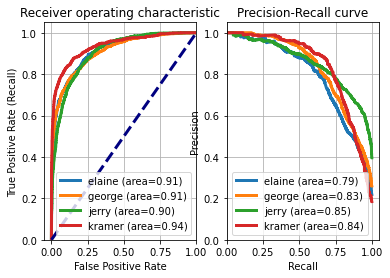

In [181]:
## Plot roc
fig, ax = plt.subplots(nrows=1, ncols=2)
classes = ('elaine','george','jerry','kramer')
for i in range(num_classes):
    fpr, tpr, thresholds = metrics.roc_curve(test_vals_roc[:,i],  
                           preds[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(num_classes):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 test_vals_roc[:,i], preds[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'elaine'),
  Text(0, 1.5, 'george'),
  Text(0, 2.5, 'jerry'),
  Text(0, 3.5, 'kramer')])

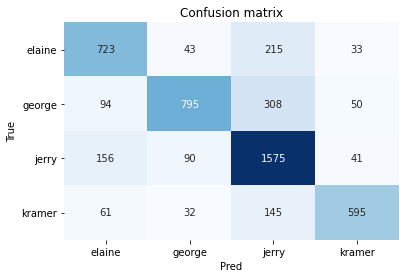

In [186]:
## Plot confusion matrix
cm = metrics.confusion_matrix(val_label, pred_labels)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [191]:
## AUC
auc = metrics.roc_auc_score(val_label, preds, 
                            multi_class="ovr")
print("Auc:", round(auc,2))

Auc: 0.92
